In [ ]:
import os
from datetime import datetime
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [3]:
dataset_files = glob.glob('../data/processed/dataset_*.csv')
if dataset_files:
    latest_dataset_file = max(dataset_files, key=os.path.getmtime)
else:
    latest_dataset_file = None

latest_dataset_file

'../data/processed/dataset_2025-08-10-17-53.csv'

In [4]:
dataset = pd.read_csv(latest_dataset_file)


In [5]:
split_day = int(dataset['time_since_test_start'].quantile(0.8))
split_day

21

In [6]:
train = dataset[dataset['time_since_test_start'] <= split_day]
test = dataset[dataset['time_since_test_start'] > split_day]

In [7]:
features = [
    'age', 'months_since_register', 'credit_card_limit',
    'is_new_customer', 'is_continuous_customer', 'is_tenured_customer', 'is_high_tenured_customer', 'is_extreme_tenured_customer',
    'has_email', 'has_mobile', 'has_social', 'has_web',
    'hist_spent', 'hist_count', 'rolling_spent_30d', 'rolling_count_30d', 'hist_offer_completion_rate',
    'discount_value', 'min_value', 'duration',
]

cat_features = ['offer_type', 'gender']

X_train = train[features + cat_features]
y_train = train['label']
X_test = test[features + cat_features]
y_test = test['label']


In [8]:
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_features)
], remainder='passthrough')

clf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [9]:
clf.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Avaliação

In [10]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      7433
           1       0.76      0.85      0.81      6989

    accuracy                           0.80     14422
   macro avg       0.80      0.80      0.80     14422
weighted avg       0.81      0.80      0.80     14422

ROC AUC: 0.8934230063860226


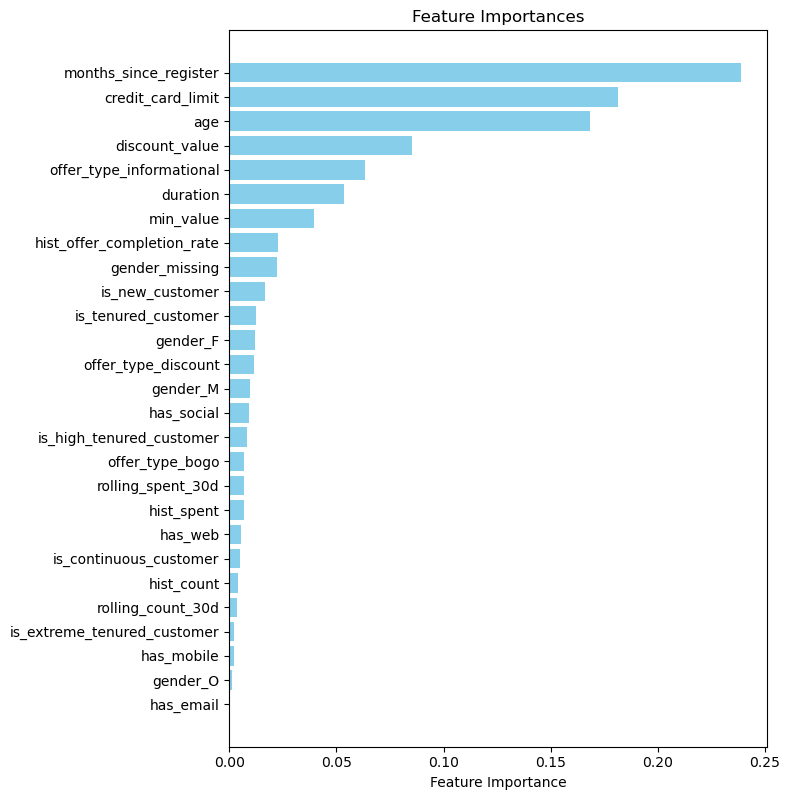

In [11]:
model = clf.named_steps['model']
encoder = clf.named_steps['prep'].named_transformers_['cat']
cat_names = encoder.get_feature_names_out(cat_features)
all_feature_names = list(cat_names) + features

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, max(4, len(importances)*0.3)))
plt.barh(range(len(importances)), importances[indices], color='skyblue')
plt.yticks(range(len(importances)), [all_feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


# Report

In [12]:
cr_dict = classification_report(y_test, y_pred, output_dict=True)

rows = []
for label, metrics in cr_dict.items():
    if label in ['accuracy', 'macro avg', 'weighted avg']:
        if label == 'accuracy':
            rows.append({'metric': 'accuracy', 'class': '', 'value': metrics})
        else:
            for m, v in metrics.items():
                rows.append({'metric': m, 'class': label, 'value': v})
    else:
        for m, v in metrics.items():
            rows.append({'metric': m, 'class': label, 'value': v})

df_metrics = pd.DataFrame(rows)

df_metrics = pd.concat([df_metrics, pd.DataFrame([{
    'metric': 'roc_auc', 'class': '', 'value': roc_auc_score(y_test, y_proba)
}])], ignore_index=True)

fi_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)


In [13]:
metadata = {
    'model_name': 'RandomForest',
    'run_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'description': 'Baseline Random Forest with historical, rolling features, tenure from customers and credit card limit',
    'features': ','.join(train.columns.to_list())
}


df_metrics['type'] = 'metric'
df_metrics['model_name'] = metadata['model_name']
df_metrics['run_date'] = metadata['run_date']
df_metrics['description'] = metadata['description']
df_metrics['features'] = metadata['features']

fi_df = fi_df.rename(columns={'feature': 'name', 'importance': 'value'})
fi_df['type'] = 'feature_importance'
fi_df['class'] = ''  # same columns as df_metrics for consistency
fi_df['metric'] = '' # fill empty for columns not relevant to features
fi_df['model_name'] = metadata['model_name']
fi_df['run_date'] = metadata['run_date']
fi_df['description'] = metadata['description']
fi_df['features'] = metadata['features']


cols = ['type', 'metric', 'class', 'name', 'value', 'model_name', 'run_date', 'description', 'features']

df_metrics['name'] = df_metrics['metric']
df_metrics['value'] = df_metrics['value']

df_metrics_final = df_metrics.rename(columns={'value': 'value'})[cols]
fi_df_final = fi_df[cols]

combined = pd.concat([df_metrics_final, fi_df_final], ignore_index=True)

In [14]:
today = datetime.now().date()
output_dir = f'../data/predictions/{str(today)}'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f'model_evaluation_combined_{metadata["run_date"]}.csv')
combined.to_csv(output_path, index=False)